In [12]:
import mira
import anndata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mira.plots.base import map_plot, plot_umap

In [3]:
rna_data = anndata.read_h5ad('data/shareseq/hf_minimal.h5ad')

In [40]:
rna_model = mira.topics.ExpressionTopicModel.load('/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/shareseq_rna_model_rev1.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [43]:
atac_data = anndata.AnnData(obs = rna_data.obs)

In [53]:
atac_data.obsm["X_topic_compositions"] = rna_data.obs.loc[:,rna_data.obs.columns.str.endswith('_atac')].values

In [103]:
bc = 0.25

rna_model.get_umap_features(rna_data, box_cox=bc)
rna_model.get_umap_features(atac_data, box_cox=bc)
rna_data.obsm['X_joint_umap_features'] = np.hstack([rna_data.obsm['X_umap_features'], atac_data.obsm['X_umap_features']])
sc.pp.neighbors(rna_data, use_rep='X_joint_umap_features', metric='manhattan')

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


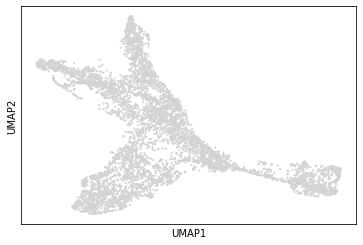

In [104]:
sc.tl.umap(rna_data, min_dist=0.1)
sc.pl.umap(rna_data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 5 diffusion map components.


/Users/alynch/projects/multiomics/mira/mira/mira/plots/eigengap_plot.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(len(eigvals)-1), eigvals[1:], '--bo', c = 'black')


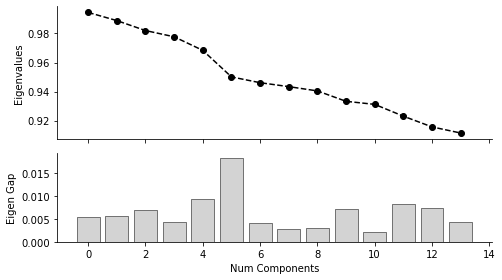

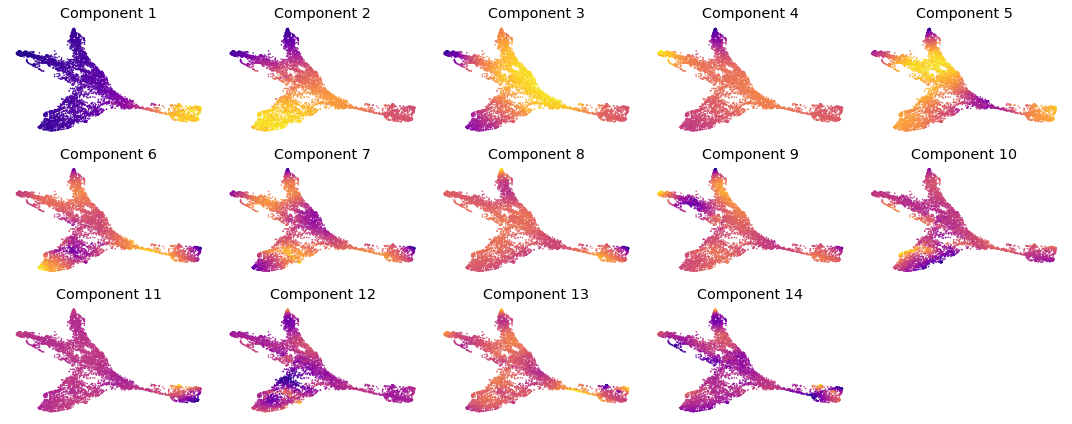

In [68]:
sc.tl.diffmap(rna_data)
mira.time.normalize_diffmap(rna_data)
mira.pl.plot_eigengap(rna_data)
plt.show()

In [69]:
sc.pp.neighbors(rna_data, use_rep='X_diffmap', key_added='X_diffmap', n_pcs = 5)

In [70]:
mira.time.get_transport_map(rna_data, start_cell='R1.64.R2.42.R3.28.P1.55')

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.
Calculating pseudotime:   8%|▉           | 4393/54900 [00:00<00:07, 6385.38it/s]
INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


INFO:mira.pseudotime.pseudotime:Found 6 terminal states from stationary distribution.


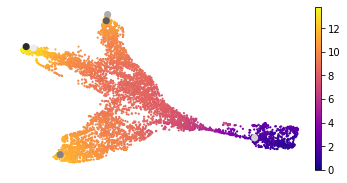

In [91]:
terminal_cells = mira.time.find_terminal_cells(rna_data, threshold=1e-2)

import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(6,3))
sc.pl.umap(rna_data, color = 'mira_pseudotime', color_map = 'plasma', frameon=False, ax=ax, show=False)
for i, c in enumerate(terminal_cells):
    sc.pl.umap(rna_data[c], na_color = sns.color_palette('Greys')[i], frameon=False, ax=ax, show=False,
              size = 200)

In [92]:
terminal_cells = ['R1.09.R2.82.R3.15.P1.56', 'R1.61.R2.10.R3.44.P1.56',
       'R1.35.R2.37.R3.92.P1.54']

In [93]:
mira.time.get_branch_probabilities(rna_data, 
                                   terminal_cells = dict(zip(['IRS','Medulla','Cortex'], terminal_cells)))

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


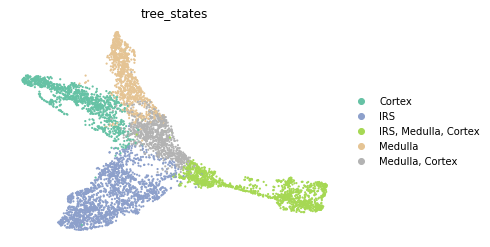

In [96]:
mira.time.get_tree_structure(rna_data, threshold=1.5)
sc.pl.umap(rna_data, color = 'tree_states', palette='Set2', frameon=False)